# Optimizing Enterprise Use Cases with Mistral Small 3: High-Performance Large Language Model with Low Latency
---

This notebook explores Mistral Small 3, a 24B parameter Large Language Model that achieves remarkable performance while maintaining exceptional efficiency. Released under Apache 2.0 license, the model demonstrates 81% MMLU accuracy and processes 150 tokens per second, rivaling larger models like Llama 3.3 70B while operating three times faster on identical hardware. Through practical examples in fraud detection, customer service, sentiment analysis, and emergency triage, we showcase its versatility in handling complex enterprise tasks while maintaining rapid response times.

---

## Model Card
---

**Available regions:** *US-West-2*

**Model ID:** [*Mistral-Small-24B-Instruct-2501*](https://huggingface.co/mistralai/Mistral-Small-24B-Instruct-2501)

**Multilingual:** *Supports dozens of languages, including English, French, German, Spanish, Italian, Chinese, Japanese, Korean, Portuguese, Dutch, and Polish.*

**Agent-Centric:** *Offers best-in-class agentic capabilities with native function calling and JSON outputting.*

**Advanced Reasoning:** *State-of-the-art conversational and reasoning capabilities.*

**Apache 2.0 License:** *Open license allowing usage and modification for both commercial and non-commercial purposes.*

**Context Window:** *A 32k context window.*

**System Prompt:** *Maintains strong adherence and support for system prompts.*

**Tokenizer:** *Utilizes a Tekken tokenizer with a 131k vocabulary size.*

---
## Benchmarks
---

### Human evaluations

| Category | Gemma-2-27B | Qwen-2.5-32B | Llama-3.3-70B | Gpt4o-mini |
|----------|-------------|--------------|---------------|------------|
| Mistral is better | 0.536 | 0.496 | 0.192 | 0.200 |
| Mistral is slightly better | 0.196 | 0.184 | 0.164 | 0.204 |
| Ties | 0.052 | 0.060 | 0.236 | 0.160 |
| Other is slightly better | 0.060 | 0.088 | 0.112 | 0.124 |
| Other is better | 0.156 | 0.172 | 0.296 | 0.312 |

### Instruct performance

**Reasoning & Knowledge**

| Evaluation | mistral-small-24B-instruct-2501 | gemma-2b-27b | llama-3.3-70b | qwen2.5-32b | gpt-4o-mini-2024-07-18 |
|------------|---------------|--------------|---------------|---------------|-------------|
| mmlu_pro_5shot_cot_instruct | 0.663 | 0.536 | 0.666 | 0.683 | 0.617 |
| gpqa_main_cot_5shot_instruct | 0.453 | 0.344 | 0.531 | 0.404 | 0.377 |

**Math & Coding**

| Evaluation | mistral-small-24B-instruct-2501 | gemma-2b-27b | llama-3.3-70b | qwen2.5-32b | gpt-4o-mini-2024-07-18 |
|------------|---------------|--------------|---------------|---------------|-------------|
| humaneval_instruct_pass@1 | 0.848 | 0.732 | 0.854 | 0.909 | 0.890 |
| math_instruct | 0.706 | 0.535 | 0.743 | 0.819 | 0.761 |

**Instruct following**

| Evaluation | mistral-small-24B-instruct-2501 | gemma-2b-27b | llama-3.3-70b | qwen2.5-32b | gpt-4o-mini-2024-07-18 |
|------------|---------------|--------------|---------------|---------------|-------------|
| mtbench_dev | 8.35 | 7.86 | 7.96 | 8.26 | 8.33 |
| wildbench | 52.27 | 48.21 | 50.04 | 52.73 | 56.13 |
| arena_hard | 0.873 | 0.788 | 0.840 | 0.860 | 0.897 |
| ifeval | 0.829 | 0.8065 | 0.8835 | 0.8401 | 0.8499 |


---
## Getting Started
---

In [ ]:
%pip install --upgrade --quiet sagemaker>=2.237.1
#%pip install --upgrade --quiet pip
%pip install langchain-aws==0.2.12 langgraph==0.2.69 PyPDF2 'llmeter[plotting]' --quiet

In [ ]:
import json
from typing import TypedDict, Annotated
from IPython.display import Image

from langchain_aws.llms.sagemaker_endpoint import SagemakerEndpoint
from langchain_aws.llms.sagemaker_endpoint import LLMContentHandler
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from llmeter.endpoints import SageMakerStreamEndpoint, BedrockConverseStream
from llmeter.experiments import LatencyHeatmap

# Import the JumpStartModel class from the SageMaker JumpStart library
from sagemaker.jumpstart.model import JumpStartModel
import boto3
import sagemaker
from sagemaker.djl_inference import DJLModel

## Deploy model

***
You can now deploy the model using SageMaker JumpStart.
***

In [ ]:
# Specify the model ID for the HuggingFace Mistral Small 24B Instruct 2501 LLM model
model_id = "huggingface-llm-mistral-small-24B-Instruct-2501"
accept_eula = True
model = JumpStartModel(model_id=model_id)
predictor = model.deploy(accept_eula=accept_eula)

***
(OPTIONAL): You can also deploy the model using DJL .
***

In [ ]:
sess = sagemaker.Session() # sagemaker session for interacting with different AWS APIs

sagemaker_session_bucket = None # bucket to house artifacts
if sagemaker_session_bucket is None and sess is not None:
    sagemaker_session_bucket = sess.default_bucket()

try:
    role = sagemaker.get_execution_role() # execution role for the endpoint
except ValueError:
    iam = boto3.client("iam")
    role = iam.get_role(RoleName="sagemaker_execution_role")["Role"]["Arn"]

sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)
region = sess.boto_region_name
print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {region}")
image_uri =f"763104351884.dkr.ecr.{region}.amazonaws.com/djl-inference:0.30.0-lmi12.0.0-cu124" 

env = {}
env['HF_MODEL_ID'] = "mistralai/Mistral-Small-24B-Instruct-2501"
env['HF_TOKEN'] = "<YOUR_HF_TOKEN>" # CHANGE WITH YOUR HUGGING FACE TOKEN
env['OPTION_ROLLING_BATCH'] = "lmi-dist"
env['OPTION_DTYPE'] = "bf16"
env['OPTION_TGI_COMPAT'] = "true"
env["OPTION_MPI_MODE"] = "true"

env['OPTION_ENGINE'] = "Python"
env['OPTION_TASK'] = "text-generation"
env['OPTION_TENSOR_PARALLEL_DEGREE'] = "max"
env['OPTION_DEVICE_MAP'] = "auto"

model = DJLModel(
    role=role,
    image_uri=image_uri,
    env=env
)
predictor = model.deploy(instance_type="ml.g5.24xlarge", initial_instance_count=1)

***
In cases where the endpoint has already been deployed, we can just invoke the model directly by using the Boto3 (AWS Python SDK) to call the model endpoint
***

## Invoke the endpoint

***
### Supported Parameters
This model supports the following inference payload parameters. You may specify any subset of the parameters mentioned above while invoking an endpoint. 

* **do_sample:** If True, activates logits sampling. If specified, it must be boolean.
* **max_new_tokens:** Maximum number of generated tokens. If specified, it must be a positive integer.
* **repetition_penalty:** A penalty for repetitive generated text. 1.0 means no penalty.
* **return_full_text:** If True, input text will be part of the output generated text. If specified, it must be boolean. The default value for it is False.
* **seed**: Random sampling seed.
* **temperature:** Controls the randomness in the output. Higher temperature results in output sequence with low-probability words and lower temperature results in output sequence with high-probability words. If `temperature` -> 0, it results in greedy decoding. If specified, it must be a positive float.
* **top_k:** In each step of text generation, sample from only the `top_k` most likely words. If specified, it must be a positive integer.
* **top_p:** In each step of text generation, sample from the smallest possible set of words with cumulative probability `top_p`. If specified, it must be a float between 0 and 1.
* **details:** Return generation details, to include output token logprobs and IDs.

## Latency with LLMeter

For many LLMs, the time to process a request can significantly depend on the length (in number of tokens) of the input provided and the output generated.

We can produce a heatmap showing how latency varies by these factors, to give an idea of how optimizing your input length or generation lengths might affect the response times observed by users.

The `LatencyHeatmap` experiment automatically generates a set of request payloads with varying (approximate) input lengths and uses it to test the endpoint.

To construct the requests, we need a base text to use as a seed. The semantic aspects are not particularly important, so any sufficiently long text can serve the purpose - but remember that many LLMs have their own internal guardrails, so it's possible that the model might decline to respond in some cases.

We'd like the generated reply to be limited by the `max_tokens` parameter (so the heatmap can measure latency for various output lengths), so will engineer a prompt that encourages the model to generate as long a response as possible from the seed text:

To use Bedrock's streaming API, we can instead connect with an LLMeter `BedrockConverseStream`. If the selected Jumpstart endpoint supports model streaming, we can instead create an LLMeter `SageMakerStreamEndpoint` to handle this.

In [4]:
def bedrock_prompt_fn(prompt, **kwargs):
    formatted_prompt = f"Create a story based on the following prompt: {prompt}"
    return BedrockConverseStream.create_payload(
        formatted_prompt, inferenceConfig={"temperature": 1.0}, **kwargs
    )

def sagemaker_prompt_fn(prompt, **kwargs):
    formatted_prompt = f"Create a story based on the following prompt: {prompt}"
    return SageMakerStreamEndpoint.create_payload(
        formatted_prompt, inference_parameters={"temperature": 1.0}, **kwargs
    )

With a seed text and prompt generation function, we're ready to set up our latency heatmapping experiment.

- The `source_file` and `create_payload_fn` will be used to generate requests with various input lengths.
- The set of `input_lengths` you'd like to test is approximate, since the locally-available tokenizer won't exactly match the one used internally by the model
- The set of `output_lengths` you'd like to test may not always be reached, if the model stops generating early for the given prompts.
- The `requests_per_combination` impacts both the time to run the test and the quality of your output statistics. Note for example that it doesn't make sense to consider p95 or p99 latency on a dataset with only 10 requests!
- A higher number of concurrent `clients` will speed up the overall test run, but could cause problems if you reach quota limits (on as-a-service models) or high request volumes that start to impact response latency (see the "Load testing" section below for more details!)

Similar to low-level test Runners, the `output_path` can be used to configure where the test result data should be saved (either locally or on the Cloud).

Here we'll use the same source text as LLMeter's own examples: The text of short story "Frankenstein" by Mary Shelley:

In [5]:
!curl -o MaryShelleyFrankenstein.txt \
    https://raw.githubusercontent.com/awslabs/llmeter/main/examples/MaryShelleyFrankenstein.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  387k  100  387k    0     0  1220k      0 --:--:-- --:--:-- --:--:-- 1221k


With a source text and a function (below) to format example requests from fragments of that text, we're ready to run our experiment to measure latency across various input and output lengths:

In [6]:
def get_latency_heatmap(
    model_id: str,
    endpoint_name=None,
    source_file="MaryShelleyFrankenstein.txt"
):
    if endpoint_name is None:
        endpoint_stream = BedrockConverseStream(
            model_id=model_id,
        )
        prompt_fn = bedrock_prompt_fn
    else:
        endpoint_stream = SageMakerStreamEndpoint(
            endpoint_name,
            model_id=model_id
        )
        prompt_fn = sagemaker_prompt_fn
    
    latency_heatmap = LatencyHeatmap(
        endpoint=endpoint_stream,
        clients=4,
        requests_per_combination=20,
        output_path=f"data/llmeter/{endpoint_stream.model_id}/heatmap",
        source_file=source_file,
        input_lengths=[50, 500, 1000],
        output_lengths=[128, 256, 512],
        create_payload_fn=prompt_fn,
    )

    return latency_heatmap

### Claude 3.5 Haiku

In [20]:
latency_heatmap_claude = get_latency_heatmap(model_id="us.anthropic.claude-3-5-haiku-20241022-v1:0")
heatmap_results_claude = await latency_heatmap_claude.run()

Total requests:   0%|          | 0/180 [00:00<?, ?it/s]

#### Claude 3.5 Haiku Latency HeatMap:


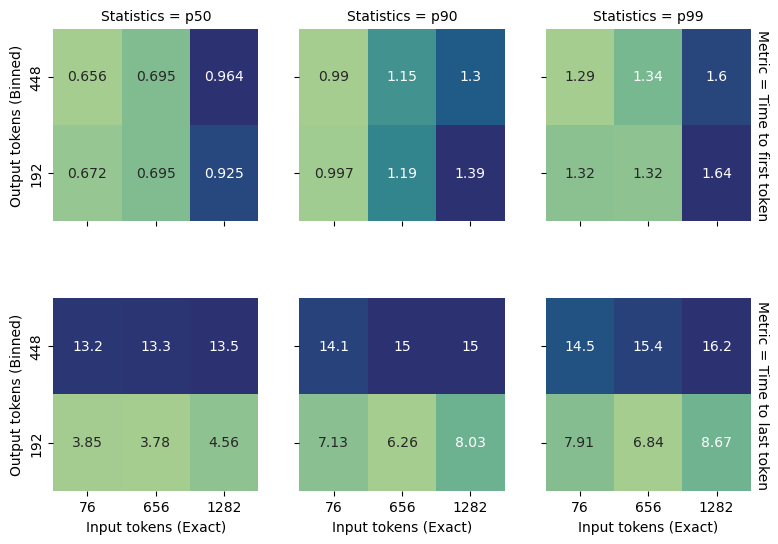

In [23]:
print(f"#### Claude 3.5 Haiku Latency HeatMap:")
fig, axs = latency_heatmap_claude.plot_heatmap()

### Mistral Small 3

In [7]:
latency_heatmap = get_latency_heatmap(model_id="Mistral-24B-Instruct-2501", endpoint_name=predictor.endpoint_name)
heatmap_results = await latency_heatmap.run()

Total requests:   0%|          | 0/180 [00:00<?, ?it/s]

Now, you'll be able to plot the heatmap results visually to explore how the latency varies with input and output token count:

#### Mistral Small 24B Instruct 2501 on ml.g5.24xlarge:


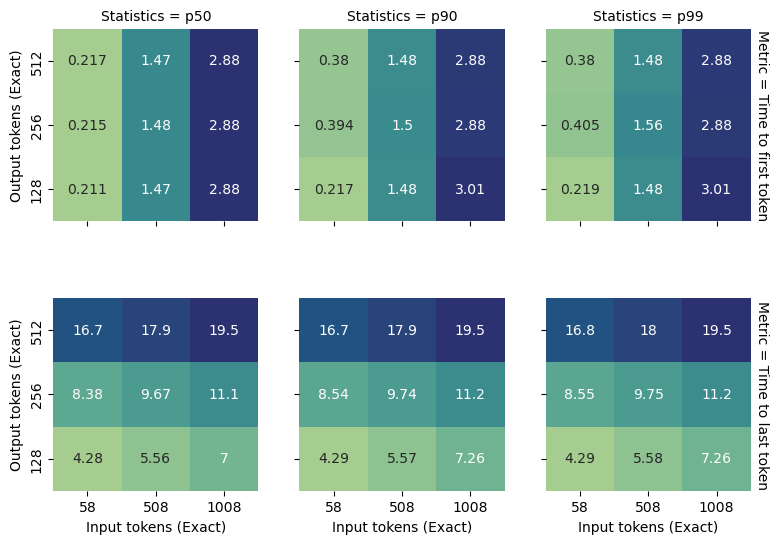

In [9]:
print(f"#### Mistral Small 24B Instruct 2501 on ml.g5.24xlarge:")
fig, axs = latency_heatmap.plot_heatmap()

**Warning:** Before running the following benchmark with `LLMeter`, deploy an endpoint for "Mistral 24B Instruct 2501" in a `ml.g5.48xlarge` and add your endpoint name below.

In [ ]:
# Initialize sagemaker client with the endpoint created in the prior step
predictor = sagemaker.Predictor(
    endpoint_name="<your endpoint name in a ml.g5.48xlarge>",
    sagemaker_session=sess,
    serializer=sagemaker.serializers.JSONSerializer(),
    deserializer=sagemaker.deserializers.JSONDeserializer(),
)

In [11]:
latency_heatmap = get_latency_heatmap(model_id="Mistral-24B-Instruct-2501", endpoint_name=predictor.endpoint_name)
heatmap_results = await latency_heatmap.run()

Total requests:   0%|          | 0/180 [00:00<?, ?it/s]

Now, you'll be able to plot the heatmap results visually to explore how the latency varies with input and output token count:

#### Mistral Small 24B Instruct 2501 on ml.g5.48xlarge:


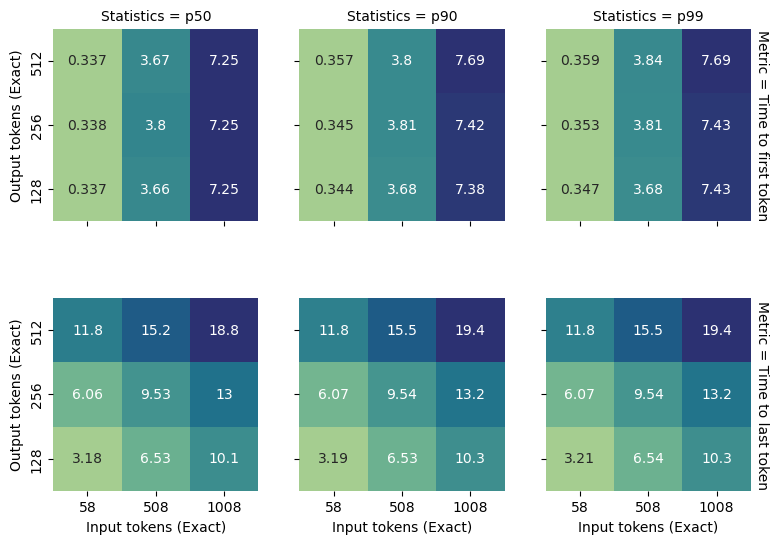

In [13]:
print(f"#### Mistral Small 24B Instruct 2501 on ml.g5.48xlarge:")
fig, axs = latency_heatmap.plot_heatmap()

### Mistral Nemo Instruct 2407

**Warning:** Before running the following benchmark with `LLMeter`, deploy an endpoint for "Mistral Nemo Instruct 2407" in a `ml.g5.24xlarge` and add your endpoint name below.

In [14]:
# Initialize sagemaker client with the endpoint created in the prior step
predictor = sagemaker.Predictor(
    endpoint_name="<your endpoint name in a ml.g5.24xlarge>",
    sagemaker_session=sess,
    serializer=sagemaker.serializers.JSONSerializer(),
    deserializer=sagemaker.deserializers.JSONDeserializer(),
)

In [15]:
latency_heatmap = get_latency_heatmap(model_id="Mistral-Nemo-Instruct-2407", endpoint_name=predictor.endpoint_name)
heatmap_results = await latency_heatmap.run()

Total requests:   0%|          | 0/180 [00:00<?, ?it/s]

Now, you'll be able to plot the heatmap results visually to explore how the latency varies with input and output token count:

#### Mistral Nemo Instruct 2407 on ml.g5.24xlarge:


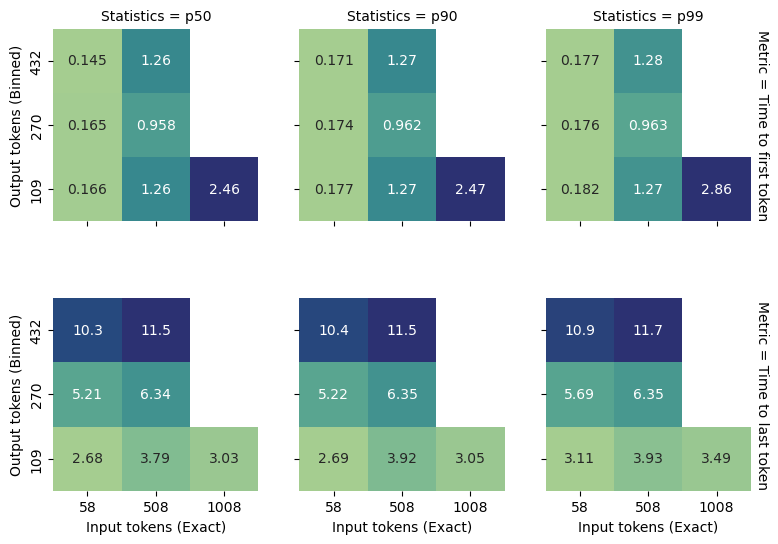

In [16]:
print(f"#### Mistral Nemo Instruct 2407 on ml.g5.24xlarge:")
fig, axs = latency_heatmap.plot_heatmap()

**Warning:** Before running the following benchmark with `LLMeter`, deploy an endpoint for "Mistral Nemo Instruct 2407" in a `ml.g5.48xlarge` and add your endpoint name below.

In [17]:
# Initialize sagemaker client with the endpoint created in the prior step
predictor = sagemaker.Predictor(
    endpoint_name="<your endpoint name in a ml.g5.48xlarge>",
    sagemaker_session=sess,
    serializer=sagemaker.serializers.JSONSerializer(),
    deserializer=sagemaker.deserializers.JSONDeserializer(),
)

In [18]:
latency_heatmap = get_latency_heatmap(model_id="Mistral-Nemo-Instruct-2407", endpoint_name=predictor.endpoint_name)
heatmap_results = await latency_heatmap.run()

Total requests:   0%|          | 0/180 [00:00<?, ?it/s]

Now, you'll be able to plot the heatmap results visually to explore how the latency varies with input and output token count:

#### Mistral Nemo Instruct 2407 on ml.g5.48xlarge:


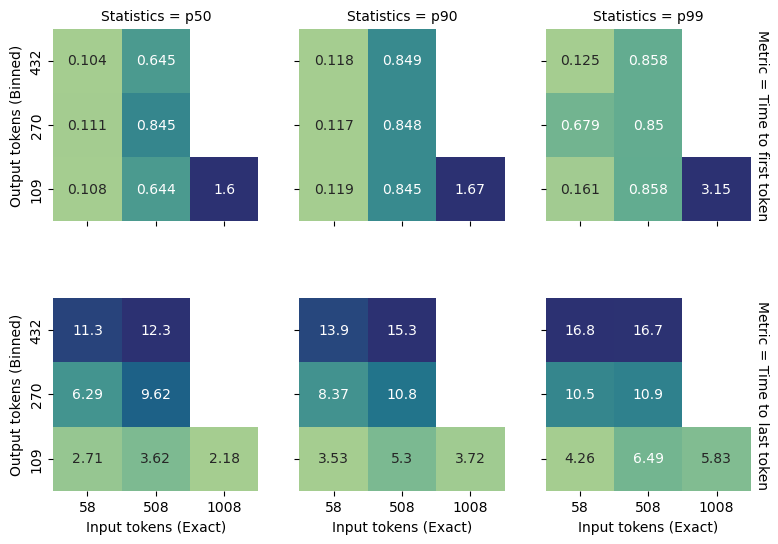

In [19]:
print(f"#### Mistral Nemo Instruct 2407 on ml.g5.48xlarge:")
fig, axs = latency_heatmap.plot_heatmap()

## Observations:

### Infrastructure Impact

1. Instance Type Effects:
   - Upgrading from g5.24xlarge to g5.48xlarge doesn't consistently improve latency
   - Mistral Nemo shows better performance on 48xlarge instances
   - Mistral Small 24B sometimes performs worse on larger instances

2. Resource Utilization:
   - Smaller models (Haiku, Nemo) demonstrate more efficient resource utilization
   - Larger instances show diminishing returns for smaller sequence lengths
   - Resource efficiency decreases non-linearly with sequence length

### Practical Implications

3. Optimization Opportunities:
   - Short sequence operations benefit most from smaller models
   - Instance size selection should be model-specific
   - Batch size optimization could potentially improve throughput

4. Cost-Performance Tradeoffs:
   - Smaller models on smaller instances often provide better price/performance
   - Larger instances may be justified for specific high-throughput scenarios
   - Model selection should consider both latency requirements and sequence length distributions

### Production Considerations

5. SLA Planning:
   - P99 latencies should be used for conservative SLA planning
   - Buffer time should account for 2-3x p50 latency for reliable service
   - Sequence length limits may be necessary for consistent performance

6. Deployment Recommendations:
   - Match instance type to model size and workload characteristics
   - Consider implementing dynamic scaling based on sequence length
   - Monitor tail latencies for early detection of performance degradation

### Model Performance Characteristics

7. Latency Distribution
    - Claude 3.5 Haiku: Most consistent p50-p99 spread
    - Mistral Small: Largest p99 spikes
    - Mistral Nemo: Best tail latency control


8. Sequence Length Impact:
    - Short sequences (<256 tokens): All models perform well
    - Medium sequences (256-512 tokens): Significant performance divergence
    - Long sequences (>512 tokens): Exponential latency increase

9. Performance Predictability:
    - P50: Good indicator for average case
    - P90: Critical for capacity planning
    - P99: Essential for SLA definitions

10. Resource Scaling Effects:
    - Instance size impact varies by model
    - Larger instances don't guarantee better p99 performance
    - Model architecture influences resource utilization efficiency

Based on the latency analysis, Mistral Nemo on g5.48xlarge delivers the best performance for real-time applications requiring shorter responses (<256 tokens) with consistent sub-second p50 latencies, while Mistral Small 24B maintains reliable performance (though with higher latencies) for inputs up to 1008 tokens and outputs up to 512 tokens. While Claude 3.5 Haiku shows consistent performance patterns in our tests (up to 1282 input tokens), actual performance on Bedrock can vary significantly based on service quotas and concurrent request limits, requiring careful capacity planning for production deployments. These findings suggests that model selection should be heavily influenced by specific latency requirements and reliability needs, with careful consideration of the entire latency distribution rather than just median performance.

## Fraud Detection

In this example, we evaluate Mistral Small 3's ability to detect financial fraud and security threats. The model demonstrates advanced pattern recognition capabilities essential for financial services, including real-time phishing detection, transaction anomaly identification, and risk assessment. This application highlights the model's strength in providing structured reasoning with low-latency responses, crucial for time-sensitive security decisions.

### Phishing Email detection

Mistral Small 3 analyzse email content and detect sophisticated phishing attempts that evade traditional rule-based filters. The model examines linguistic patterns, sender impersonation tactics, and psychological manipulation techniques to identify both common and novel phishing strategies.

In [30]:
system_prompt = '''
Please analyze this email for potential phishing activity. Rate each indicator as 1 (present) or 0 (absent):

[SENSITIVE] Requests for sensitive data (passwords, financial, personal): [0/1]
[DOMAIN] Sender's email domain mismatches claimed company: [0/1]
[LINKS] Embedded links don't match legitimate organization domain: [0/1]
[GREETING] Generic greetings used instead of personal name: [0/1]
[ERRORS] Presence of spelling or grammatical mistakes: [0/1]
[URGENT] Uses urgent or threatening language to create panic: [0/1]

Total flags: [X/6]
Brief analysis: [1-2 sentence conclusion on whether this appears to be a phishing attempt and why]
'''
user_prompt = '''
To: john.doe@company.com
Subject: URGENT: Your Octank account has been locked

Dear Valued Customer,

We have detected unusual login activity on your Octank account from an unrecognized device. As a precautionary measure, we have temporarily limited access to your account.

To restore full account access, please verify your identity within 24 hours by clicking below:

https://0ctank-account-verify.com/unlock-account

If you do not complete this verification process within 24 hours, your account will be permanently suspended.

Best regards,
Account Security Team

-------------------
This is an automated security alert from Octank
For support: support@octank-accounts.net

'''

In [32]:
payload = {
    "messages": [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ],
    "max_tokens": 4000,
    "temperature": 0.1,
    "top_p": 0.9,
}

response = predictor.predict(payload)
print(response['choices'][0]['message']['content']) 

[SENSITIVE] Requests for sensitive data (passwords, financial, personal): [1]
[DOMAIN] Sender's email domain mismatches claimed company: [1]
[LINKS] Embedded links don't match legitimate organization domain: [1]
[GREETING] Generic greetings used instead of personal name: [1]
[ERRORS] Presence of spelling or grammatical mistakes: [1]
[URGENT] Uses urgent or threatening language to create panic: [1]

Total flags: [6/6]

Brief analysis: This email appears to be a phishing attempt due to the presence of all six indicators. The email requests sensitive information, has mismatched domains, contains a suspicious link, uses a generic greeting, has spelling errors, and employs urgent language to pressure the recipient.


### Fraudulent Call Detection

Mistral Small 3 analyzes transcripts of suspicious phone calls, identifying common deception tactics and social engineering patterns used by scammers. The system automatically flags potential fraud indicators - like urgency manipulation, impersonation of authority figures, and unusual payment requests - helping financial institutions and call centers rapidly detect and respond to emerging scam attempts while protecting vulnerable customers.

In [34]:
system_prompt = '''
Please analyze this call/message for potential scam activity. Rate each indicator as 1 (present) or 0 (absent):

[ID] Missing/incomplete identification (name/company/ID): [0/1]
[OFFER] Suspicious offers or too-good-to-be-true promises: [0/1]
[VAGUE] Non-specific references instead of account details: [0/1]
[REDIRECT] Unsolicited direction to unofficial channels: [0/1]
[URGENT] Pressure tactics or urgent deadlines: [0/1]
Total flags: [X/5]
Brief analysis: [1-2 sentence conclusion]'''

user_prompt = ''' 
Hi there, this is Jessie calling in regards to your Honda warranty. The warranty is up for renewal. 
I’d like to congratulate you on your $2,000 instant rebate and free maintenance and oil change package for being a loyal customer. 
Call me back at 934-153-XXXX to redeem now. Once again that number was 934-153-XXXX. Thank you so much. Have a great day. 
'''

In [35]:
payload = {
    "messages": [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ],
    "max_tokens": 4000,
    "temperature": 0.1,
    "top_p": 0.9,
}

response = predictor.predict(payload)
print(response['choices'][0]['message']['content']) 

[ID] Missing/incomplete identification (name/company/ID): [1] (No company name or ID provided, only a first name)
[OFFER] Suspicious offers or too-good-to-be-true promises: [1] (Instant $2,000 rebate and free maintenance package)
[VAGUE] Non-specific references instead of account details: [1] (No specific account details or vehicle information mentioned)
[REDIRECT] Unsolicited direction to unofficial channels: [1] (Asking to call back a phone number)
[URGENT] Pressure tactics or urgent deadlines: [1] (Urging to "redeem now")
Total flags: [5/5]

Brief analysis: This message exhibits all the classic signs of a scam, including a lack of proper identification, an enticing offer, vague details, redirection to an unofficial channel, and pressure tactics.


## Virtual Customer Service

The customer service demonstration showcases Mistral Small 3's prowess in maintaining contextual awareness during technical support conversations. We test its ability to provide accurate AWS-specific guidance while maintaining conversation flow and context. This example particularly highlights the model's fast-response capabilities and efficient memory management in multi-turn dialogues, essential features for real-world customer support applications.

In [36]:
from typing import Dict, List
from IPython.display import Markdown, display


def chat_history_to_string(memory):
    history_str = ""
    for chat_item in memory:
        role = chat_item.get("role", "")
        content = chat_item.get("content", "")
        history_str += f"{role}: {content}\n\n"
    return history_str.strip()


def format_conversation(user_input: str, memory: List[Dict[str, str]] = []) -> str:
    
    history = chat_history_to_string(memory)
    
    prompt = f"""
    You are a knowledgeable helpful AWS customer service assistant. You are helpful and provide general guidance from the context less than 100 words in the scope.
    {history} 
    {user_input}
    """
    return prompt


def chat_with_agent(user_input: str, memory: List[Dict[str, str]]):
    # Format the conversation using the helper functions
    formatted_prompt = format_conversation(user_input, memory)
    
    # Create payload with the formatted prompt
    payload = {
        "messages": [{"role": "user", "content": formatted_prompt}],
        "max_tokens": 400,
        "temperature": 0.1,
        "top_p": 0.9,
    }
    
    # Get response
    response = predictor.predict(payload)
    response_content = response['choices'][0]['message']['content']
    
    # Display response
    display(Markdown(response_content))
    
    # Update memory
    memory.append({"role": "user", "content": user_input})
    memory.append({"role": "assistant", "content": response_content})
    
    return response_content

In [37]:
memory = []
chat_with_agent("Hi there", memory);

Hello! How can I assist you today with AWS?

In [38]:
chat_with_agent("How to select an EC2 instance type?", memory);

To select an EC2 instance type, consider the following:

1. **Workload Requirements**: Identify the performance needs of your application (CPU, memory, storage, networking).
2. **Instance Families**: Choose from families like General Purpose, Compute Optimized, Memory Optimized, Storage Optimized, or GPU instances.
3. **Pricing**: Compare On-Demand, Reserved, and Spot Instances based on your budget and usage patterns.
4. **AWS Free Tier**: If you're new, consider using the Free Tier for eligible instances.
5. **AWS Pricing Calculator**: Use this tool to estimate costs based on your selected instance type and usage.

For specific recommendations, please provide more details about your workload.

In [39]:
chat_with_agent("Cool. Will that work for my Linux workload?", memory);

For a Linux workload, the selection of an EC2 instance type depends on your specific requirements. Here are some general guidelines:

1. **General Purpose**: For balanced CPU and memory needs, consider instances like `t3`, `m5`, or `m6g`.
2. **Compute Optimized**: If your workload is CPU-intensive, look at `c5` or `c6g` instances.
3. **Memory Optimized**: For memory-intensive applications, `r5` or `r6g` instances are suitable.
4. **Storage Optimized**: If you need high I/O performance, consider `i3` or `i3en` instances.
5. **Cost-Effective**: For cost-sensitive workloads, `t3` or `t4g` instances can be a good fit.

For more tailored advice, please provide details on your specific Linux workload requirements, such as CPU, memory, storage, and networking needs.

## Sentiment Analysis

Our sentiment analysis implementation leverages Mistral Small 3's high-throughput text processing capabilities, focusing on financial news and market sentiment. The model exhibits consistent performance in categorical classification while maintaining rapid processing speeds. This example demonstrates the model's ability to handle varied content types while providing reliable, structured outputs suitable for automated trading and market analysis systems.

In [40]:
system_prompt = """ Respond with "positive" or "neutral" or "negative" and nothing else for the following 3 statements. """

user_prompt1 = """ I absolutely love this new phone, it's amazing how fast it works and the camera quality is incredible. """
user_prompt2 = """ The weather today is cloudy with some sun, temperature around 70 degrees. """
user_prompt3 = """ This is the worst customer service I've ever experienced. They lost my order and refused to help me resolve the issue. """

In [41]:
payload = {
    "messages": [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt1+user_prompt2+user_prompt3}
    ],
    "max_tokens": 10,
    "temperature": 0.1,
    "top_p": 0.9,
}

response = predictor.predict(payload)
print(response['choices'][0]['message']['content'])

Positive
Neutral
Negative


## Healthcare

Healthcare professionals struggle to efficiently process large volumes of medical text under time pressure. These examples showcases how Mistral Small 3 can transform complex medical content - from patient records to research papers - into focused, actionable insights. Mistral extracts and prioritizes critical information while maintaining clinical accuracy and relevance, enabling healthcare providers to make better-informed decisions quickly. 

### Medical Research Paper Analysis

Medical professionals face an overwhelming challenge keeping pace with the exponentially growing body of clinical research, where thousands of new studies are published daily across numerous specialties. Mistral Small 3 can help clinicians efficiently process and evaluate research papers by automatically identifying crucial elements including study design, population characteristics, primary outcomes, statistical significance, and potential methodological limitations.

**Dataset Details:**

+ **Repository:** [PubMed Central (PMC)](https://pmc.ncbi.nlm.nih.gov/) 
+ Research article: [Clinical Trials and Clinical Research: A Comprehensive Review](https://pmc.ncbi.nlm.nih.gov/articles/PMC10023071/pdf/cureus-0015-00000035077.pdf)

**Description:**

PubMed Central (PMC) serves as a central repository to archive biomedical and life sciences literature maintained by the U.S. National Institutes of Health's National Library of Medicine (NIH/NLM) for free full-text research papers, enabling broad access to scientific knowledge in the medical and life sciences domains.

Key aspects:

+ Acts as a freely accessible digital repository of full-text biomedical and life sciences research articles, promoting open access to scientific literature
+ Maintained by NIH/NLM, ensuring high-quality curation and reliable archiving of scientific publications
+ Facilitates comprehensive access to clinical trials and research papers, supporting evidence-based medical practice and research advancement

In [6]:
import requests

def download_pdf(url, output_filename):
    # Headers to mimic a browser request
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
        'Accept-Language': 'en-US,en;q=0.9',
        'Referer': 'https://www.google.com'
    }
    
    try:
        # Send GET request with headers
        response = requests.get(url, headers=headers, stream=True)
        
        # Check if the request was successful
        if response.status_code == 200:
            return response.content
        else:
            print(f"Failed to download PDF. Status code: {response.status_code}")
            
    except Exception as e:
        print(f"An error occurred: {str(e)}")

In [7]:
url = "https://pmc.ncbi.nlm.nih.gov/articles/PMC10023071/pdf/cureus-0015-00000035077.pdf"
filename = 'Clinical Trials and Clinical Research.pdf'
research_article = download_pdf(url, filename)

In [8]:
import io
from PyPDF2 import PdfReader

def parse_pdf_bytes(pdf_bytes):
    """Parses PDF content from bytes and returns the text."""
    pdf_file = io.BytesIO(pdf_bytes)
    reader = PdfReader(pdf_file)
    text_content = ""
    for page in reader.pages:
        text_content += page.extract_text() + "\n"
    return text_content

In [10]:
doc = parse_pdf_bytes(research_article)

In [15]:
prompt = f""""
You are a medical research analyst helping clinicians evaluate scientific papers. For each paper:
- Summarize the key findings and clinical implications
- Evaluate the methodology and study design
- Highlight potential limitations or biases
- Compare findings with existing literature
- Suggest practical applications
Use evidence-based analysis and maintain scientific rigor. Flag any potential conflicts of interest or statistical concerns.

<RESEARCH_PAPER>
{doc}
</RESEARCH_PAPER>
"""

payload = {
    "messages": [
        {
            "role": "user",
            "content": prompt
        }
    ],
    "max_tokens": 4000,
    "temperature": 0.1,
    "top_p": 0.9,
}

response = predictor.predict(payload)
print(response['choices'][0]['message']['content'])

### Summary of Key Findings and Clinical Implications

**Key Findings:**
1. **Definition and Importance of Clinical Research:** Clinical research is defined as the study of the safety and efficacy of drugs, devices, or procedures in treating, preventing, or diagnosing diseases. It is crucial for public health, especially in the context of emerging diseases like COVID-19.
2. **Phases of Clinical Trials:** The paper outlines the different phases of clinical trials, from Phase 0 (micro-dosing studies) to Phase IV (post-approval studies), each with specific objectives and methodologies.
3. **Types of Clinical Trial Designs:** Various designs are discussed, including parallel, crossover, factorial, randomized withdrawal, and adaptive designs, each with its advantages and disadvantages.
4. **Ethical Considerations:** The paper emphasizes the ethical guidelines and principles that must be followed in clinical research, including informed consent, beneficence, and justice.
5. **Regulatory and 

### Clinical Note Summarization

Emergency department physicians face the critical challenge of rapidly processing extensive patient histories while making time-sensitive medical decisions. This example showcases how to transform lengthy clinical documentation into concise, clinically relevant summaries. Mistral Small 3 analyzes multiple sources including previous visit notes, discharge summaries, and specialist consultations, extracting key information about past medical conditions, current medications, allergies, and recent interventions.

**Dataset Details:**

+ **Dataset Name:** [aisc-team-a1/augmented-clinical-notes](https://huggingface.co/datasets/aisc-team-a1/augmented-clinical-notes) 
+ **Language(s):** English only
+ **Repository:** [EPFL-IC-Make-Team/ClinicalNotes](https://github.com/EPFL-IC-Make-Team/medinote)
+ Paper: MediNote: Automated Clinical Notes

**Description:**

This is a medical dataset developed for the AISC class at Harvard Medical School, comprising 30,000 clinical note triplets. The dataset combines real clinical notes from PMC-Patients, synthetic doctor-patient dialogues (NoteChat), and structured patient information, serving as the foundation for training MediNote-7B and MediNote-13B clinical note generators.

Key components:

+ Real clinical notes are sourced from PubMed Central case studies through the PMC-Patients dataset, providing detailed patient summaries, medical histories, treatments, and outcomes
+ Synthetic dialogues were generated using GPT-3.5 to address the scarcity of real patient-doctor conversation data due to confidentiality constraints
+ Structured patient information was extracted from the 30,000 longest clinical notes using GPT-4, following a specialized medical information template

In [16]:
from datasets import load_dataset

In [21]:
dataset = load_dataset("aisc-team-a1/augmented-clinical-notes", split='train[:1%]')

Using custom data configuration aisc-team-a1--augmented-clinical-notes-cf72aac0a94766e5


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /home/sagemaker-user/.cache/huggingface/datasets/aisc-team-a1___parquet/aisc-team-a1--augmented-clinical-notes-cf72aac0a94766e5/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


In [28]:
medical_note = dataset['full_note'][0]

prompt = f""""
You are a clinical documentation specialist tasked with summarizing patient records. Focus on:
- Key diagnoses and dates
- Current medications and allergies
- Recent procedures or hospitalizations
- Relevant family history
- Critical lab values
Present information in a structured format prioritizing recent and clinically significant findings. Flag any critical values or concerning trends. Use standard medical terminology and maintain all dates and specific values exactly as provided.

<MEDICAL_NOTE>
{medical_note}
</MEDICAL_NOTE>
"""

payload = {
    "messages": [
        {
            "role": "user",
            "content": prompt
        }
    ],
    "max_tokens": 4000,
    "temperature": 0.1,
    "top_p": 0.9,
}

response = predictor.predict(payload)
print(response['choices'][0]['message']['content'])

### Patient Summary

**Patient Information:**
- Age: 16 years old
- Gender: Female
- Diagnosis: Bipolar Affective Disorder, Tardive Dystonia

**Key Diagnoses and Dates:**
- **Bipolar Affective Disorder:** Diagnosed at age 11
- **Tardive Dystonia:** Developed within the second week of olanzapine use at age 11, persisted and exacerbated with reintroduction of olanzapine

**Current Medications:**
- **Tetrabenazine:** 75 mg per day in divided doses (started recently)
- **Lithium:** 450 mg per day
- **Eltroxin:** 50 micrograms per day

**Allergies:**
- None mentioned

**Recent Procedures or Hospitalizations:**
- None mentioned

**Relevant Family History:**
- None mentioned

**Critical Lab Values:**
- **Thyroid Function Tests:** Deranged subsequent to the introduction of lithium carbonate, normalized after the introduction of eltroxin

**Clinical Course and Significant Findings:**
- **Symptoms:** Discomfort in the neck and lower back, restriction of body movements, abnormal posturing of the 

## Agentic Workflow with LangGraph

First, we are initializing the ```StateGraph```. This object will encapsulate the graph being traversed during excecution.

Then we define the **nodes** in our graph. In LangGraph, nodes are typically python functions. There are two main nodes we will use for our graph:
- The agent node: responsible for deciding what (if any) actions to take.
- The tool node: This node will orchestrate calling the respective tool and returning the output. This means if the agent decides to take an action, this node will then execute that action.

**Edges** define how the logic is routed and how the graph decides to stop. This is a big part of how your agents work and how different nodes communicate with each other. There are a few key types of edges:

- Normal Edges: Go directly from one node to the next.
- Conditional Edges: Call a function to determine which node(s) to go to next.
- Entry Point: Which node to call first when user input arrives.
- Conditional Entry Point: Call a function to determine which node(s) to call first when user input arrives.

In our case we need to define a conditional edge that routes to the ```ToolNode``` when a tool get called in the agent node, i.e. when the LLM determines the requirement of tool use. With ```tools_condition```, LangGraph provides a preimplemented function handling this. Further, an edge from the ```START```node to the ```assistant```and from the ```ToolNode``` back to the ```assistant``` are required.

We are adding the nodes, edges as well as a persistant memory to the ```StateGraph``` before we compile it. 

### Define Agent State

We'll define the state that our agent will maintain throughout its operation. First, define the [State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) of the graph.  The State schema serves as the input schema for all Nodes and Edges in the graph.

Let's use the `TypedDict` class from python's `typing` module as our schema, which provides type hints for the keys.

### Key Components

1. **StateGraph**: The core of our application, defining the flow of our Travel Planner.
2. **PlannerState**: A custom type representing the state of our planning process.
3. **Node Functions**: Individual steps in our planning process (input_city, input_interests, create_itinerary).
4. **LLM Integration**: Utilizing a language model to generate the final itinerary.
5. **Memory Integration**: Utilizing long term and short term memory for conversations

### Define Agent Nodes

we will create a simple graph with:

- user travel plans
- invoke with SageMaker JumpStart and Mistral Small 3
- generate the travel plan for the day 
- ability to add or modify the plan

In [23]:
class PlannerState(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage], "The messages in the conversation"]
    itinerary: str
    city: str
    user_message: str

### Set Up Language Model and Prompts

In [24]:
class ContentHandler(LLMContentHandler):
    content_type = "application/json"
    accepts = "application/json"

    def transform_input(self, prompt: str, model_kwargs: Dict) -> bytes:
        input_str = json.dumps(
            {"messages": [
                {
                    "role": "user",
                    "content": prompt
                }
            ],
             **model_kwargs
            }
        )
        return input_str.encode("utf-8")

    def transform_output(self, output: bytes) -> str:
        response_json = json.loads(output.read().decode("utf-8"))
        return response_json['choices'][0]['message']['content']

In [32]:
content_handler = ContentHandler()
llm = SagemakerEndpoint(
      endpoint_name="djl-inference-2025-02-03-17-38-06-513", 
      region_name="us-east-1",
      model_kwargs={"max_tokens": 1000, "top_p": 0.9,"temperature":0.6},
      content_handler=content_handler
  )


itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests. Use the below chat conversation and the latest input from Human to get the user interests. Provide a brief, bulleted itinerary."),
    MessagesPlaceholder("chat_history"),
    ("human", "{user_message}"),
])

### Define the nodes and Edges

In [34]:
def input_interests(state: PlannerState) -> PlannerState:
    user_message = state['user_message'] #input("Your input: ")
    #print(f"We are going to :: {user_message}:: for trip to {state['city']} based on your interests mentioned in the prompt....")

    if not state.get('messages', None) : state['messages'] = []
    return {
        **state,
    }

def create_itinerary(state: PlannerState) -> PlannerState:
    response = llm.invoke(itinerary_prompt.format_messages(city=state['city'], user_message=state['user_message'], chat_history=state['messages']))
    print("\nFinal Itinerary:")
    print(response)
    return {
        **state,
        "messages": state['messages'] + [HumanMessage(content=state['user_message']),AIMessage(content=response)],
        "itinerary": response
    }

### Create and Compile the Graph

Now we'll create our LangGraph workflow and compile it. We build the graph from our [components](
https://langchain-ai.github.io/langgraph/concepts/low_level/) defined above. The [StateGraph class](https://langchain-ai.github.io/langgraph/concepts/low_level/#stategraph) is the graph class that we can use.
 
First, we initialize a StateGraph with the `State` class we defined above. Then, we add our nodes and edges. We use the [`START` Node, a special node](https://langchain-ai.github.io/langgraph/concepts/low_level/#start-node) that sends user input to the graph, to indicate where to start our graph. The [`END` Node](https://langchain-ai.github.io/langgraph/concepts/low_level/#end-node) is a special node that represents a terminal node. 


In [35]:
workflow = StateGraph(PlannerState)

workflow.add_node("input_interests", input_interests)
workflow.add_node("create_itinerary", create_itinerary)

workflow.set_entry_point("input_interests")

workflow.add_edge("input_interests", "create_itinerary")
workflow.add_edge("create_itinerary", END)

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

### Display the graph structure

Finally, we [compile our graph](https://langchain-ai.github.io/langgraph/concepts/low_level/#compiling-your-graph) to perform a few basic checks on the graph structure. We can visualize the graph as a [Mermaid diagram](https://github.com/mermaid-js/mermaid).

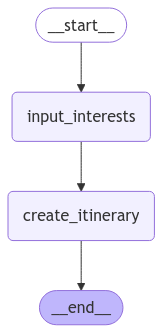

In [36]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Define the function that runs the graph

When we compile the graph, we turn it into a LangChain Runnable, which automatically enables calling `.invoke()`, `.stream()` and `.batch()` with your inputs. In the following example, we run `stream()` to invoke the graph with inputs

In [37]:
def run_travel_planner(user_request: str, config_dict: dict):
    print(f"Current User Request: {user_request}\n")
    init_input = {"user_message": user_request,"city" : "Seattle"}

    for output in app.stream(init_input, config=config_dict, stream_mode="values"):
        pass  # The nodes themselves now handle all printing

### Travel Planner Example

- To run this the system prompts and asks for user input for activities 
- We have initialized the graph state with city Seattle which usually will be dynamic and we will see in subsequrnt labs
- You can enter like boating, swiming

In [38]:
config = {"configurable": {"thread_id": "1"}}

user_request = "Can you create a itinerary for boating, swim. Need a complete plan"
run_travel_planner(user_request, config)

Current User Request: Can you create a itinerary for boating, swim. Need a complete plan


Final Itinerary:
Sure, I'd be happy to help you plan a day trip in Seattle that includes boating and swimming. Here's a brief itinerary based on your interests:

- **Morning:**
  - **9:00 AM: Start at Shilshole Bay Marina**
    - Rent a boat or join a guided tour to explore Puget Sound.
    - Enjoy the scenic views of the Seattle skyline and surrounding islands.

- **Late Morning:**
  - **11:30 AM: Lunch at Shilshole Bay Marina**
    - There are several restaurants and cafes where you can grab a bite.

- **Afternoon:**
  - **1:00 PM: Head to Golden Gardens Park**
    - Relax and enjoy the beach.
    - Take a swim in the sound if the weather permits.

- **Late Afternoon:**
  - **3:30 PM: Visit the Ballard Locks**
    - Watch the boats pass through the locks.
    - Explore the nearby gardens and fish ladder.

- **Evening:**
  - **5:30 PM: Dinner at a nearby restaurant**
    - Enjoy local cuisine at

#### Leverage the memory saver to manipulate the Graph State
- Since the `Conversation Messages` are part of the graph state we can leverage that
- However the graph state is tied to `session_id` which will be passed in as a `thread_id` which ties to a session
- If we add a request with different thread id it will create a new session which will not have the previous `Interests`
- However this this has the other check points variables as well and so this pattern is good for `A-Sync` workflow

In [39]:
config = {"configurable": {"thread_id": "1"}}

user_request = "Can you add white water rafting to this itinerary"
run_travel_planner(user_request, config)

Current User Request: Can you add white water rafting to this itinerary


Final Itinerary:
To include white water rafting in your Seattle day trip, we'll need to adjust the itinerary slightly, as white water rafting opportunities are not available within the city itself. The closest options are a bit further out. Here's a revised itinerary:

- **Morning:**
  - **7:00 AM: Depart for Leavenworth**
    - Drive to Leavenworth, WA (approx. 2.5 hours from Seattle) for white water rafting.
  - **9:30 AM: White Water Rafting**
    - Book a morning rafting trip with a local outfitter like Icicle Creek Rafting or Wet Planet Whitewater.

- **Late Morning:**
  - **12:00 PM: Lunch in Leavenworth**
    - Grab a quick bite in Leavenworth before heading back to Seattle.

- **Afternoon:**
  - **1:30 PM: Return to Seattle**
    - Drive back to Seattle (approx. 2.5 hours).
  - **4:00 PM: Head to Golden Gardens Park**
    - Relax and enjoy the beach.
    - Take a swim in the sound if the weather permits.


## Overall Conclusions:

Mistral Small 3 establishes itself as a powerful, versatile model that successfully balances performance with efficiency. Its ability to match larger models while maintaining significantly lower latency makes it particularly suitable for production deployments. The model's Apache 2.0 license and efficient resource utilization make it an attractive option for both enterprise applications and local deployments. Our testing confirms its capability to handle complex tasks while maintaining the speed and reliability necessary for real-world applications.